# Combine https results from WARC and from Backcheck against the domains

In [33]:
import numpy as np
import pandas as pd
import json


In [37]:
https_dima = pd.read_csv("/project/1_feature_extraction/extract_https/sirens_final_https.csv")
#https.set_index('domain', inplace = True)
print(https_dima.shape)
https_dima.head()

(3767, 7)


,domain,siren,origin,wapps,Website,https,status
0,www.easypets.fr,530772565,warc,['PrestaShop'],https://www.easypets.fr/fr/,1.0,200.0
1,www.a4.fr,388336000,web,['Magento'],https://www.a4.fr/,1.0,200.0
2,www.laptopservice.fr,519216188,web,['PrestaShop'],https://www.laptopservice.fr/,1.0,200.0
3,www.toutespiecesanspermis.fr,382528958,web,['PrestaShop'],https://www.toutespiecesanspermis.fr/,1.0,200.0
4,www.studiosport.fr,495049132,web,['OpenCart'],https://www.studiosport.fr/,1.0,200.0


In [78]:
### take care of multiple sirens in https_dima, limit to size of dataframe for analysis
# apply rule that if one of the domains for a shop has got an https flag it is assumed that
# the entire siren with all its domains is using this protocol
https_dima_unique = https_dima.groupby('siren')['Website', 'https'].max().reset_index()
https_dima_unique.set_index('siren', inplace = True)
print(https_dima_unique.shape)
https_dima_unique.head()

(3573, 2)


,Website,https
siren,,
6580195,offline,NaN
7220338,https://www.vannerie-du-boisle.fr/,1.0
15751530,offline,NaN
57813677,https://www.empereur.fr/,1.0
65501850,offline,NaN


In [79]:
### READ DATA
features = pd.read_csv("/project/1_feature_extraction/output_feature_extraction/final/features_all.csv")
features.rename(columns={features.columns[0]: 'siren'}, inplace=True)
features.set_index('siren', inplace = True)
print("Features Shape: ", features.shape)
features.head()

http_original = features[['https_flag', 'label']]
print("HttpsFlag Subset: ", http_original.shape)

http_original.head()

Features Shape:  (3063, 36)
HttpsFlag Subset:  (3063, 2)


,https_flag,label
siren,,
530772565,1,1
388336000,1,0
519216188,1,0
382528958,0,0
495049132,1,0


In [80]:
# join on sirens, left join on data used in the analysis
https_join=http_original.join(https_dima_unique)
print(https_join.shape)
https_join.head()

(3063, 4)


,https_flag,label,Website,https
siren,,,,
530772565,1,1,https://www.easypets.fr/fr/,1.0
388336000,1,0,offline,1.0
519216188,1,0,https://www.laptopservice.fr/,1.0
382528958,0,0,https://www.toutespiecesanspermis.fr/,1.0
495049132,1,0,https://www.studiosport.fr/,1.0


In [81]:
https_join = https_join.replace(np.nan, 'offline')
https_join.head()

,https_flag,label,Website,https
siren,,,,
530772565,1,1,https://www.easypets.fr/fr/,1
388336000,1,0,offline,1
519216188,1,0,https://www.laptopservice.fr/,1
382528958,0,0,https://www.toutespiecesanspermis.fr/,1
495049132,1,0,https://www.studiosport.fr/,1


In [82]:
https_join.groupby(['https_flag', 'https']).size().squeeze()

https_flag  https  
0           0.0         202
            1.0        1035
            offline     648
1           0.0          18
            1.0        1120
            offline      40
dtype: int64

In [89]:
# define rules for reclassification:
# new data takes precedence over warc, if new empty, then keep previous flag
new = []
for i in range(len(https_join)):
    if https_join.iloc[i, 3] == "offline":
        new.append(https_join.iloc[i, 0])
    else:
        new.append(https_join.iloc[i, 3])
    
https_join['https_merge']=new

# save as csv
https_join.to_csv('https_merged.csv')

https_join.head()

,https_flag,label,Website,https,https_merge
siren,,,,,
530772565,1,1,https://www.easypets.fr/fr/,1,1.0
388336000,1,0,offline,1,1.0
519216188,1,0,https://www.laptopservice.fr/,1,1.0
382528958,0,0,https://www.toutespiecesanspermis.fr/,1,1.0
495049132,1,0,https://www.studiosport.fr/,1,1.0


In [74]:
https_join['https_merge'].sum()

2195.0

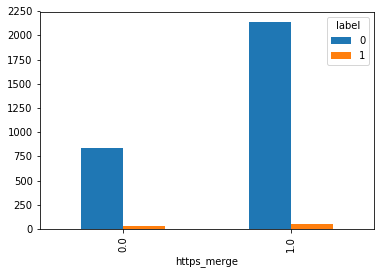

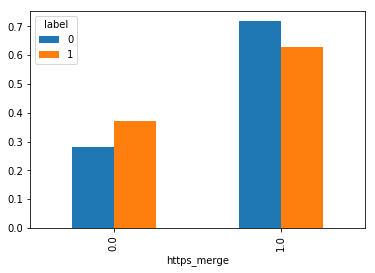

In [87]:
import matplotlib.pyplot as plt
data = https_join.groupby(['https_merge', 'label']).size().squeeze().unstack()



#features.groupby([col, 'label']).size().squeeze().unstack()
data.plot(kind='bar')#, stacked=True)
plt.savefig("/project/2_exploration/output_exploration/https_update_abs.png")

#normalize to percentage of values per category class, plot side by side with the absolute values
d = data.apply(lambda x: x/x.sum())
d.plot(kind='bar')#, stacked=True)
plt.savefig("/project/2_exploration/output_exploration/https_update_perc.png")